# LLM-Persuasion-Defense — CI Plots for Four Selected Runs

Visualize **PSR / RA / Locality** vs **Max Turns (mean ± 95% CI)** for these four summaries:
- DeepSeek + None
- DeepSeek + Override
- OpenAI + None
- OpenAI + Override

This notebook assumes your `results/` folder is **parallel to** `notebooks/`.


In [9]:
import os, glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# --- Force results/ to the folder parallel to notebooks/ ---
CWD = Path.cwd()
RESULTS_DIR = CWD.parent / "results"   # <- key: results is sibling of notebooks
if not RESULTS_DIR.exists():
    raise FileNotFoundError(f"Expected results at: {RESULTS_DIR}")

# Output plots to root-level plots/
PLOTS_DIR = RESULTS_DIR.parent / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def _glob_one(pattern: str):
    matches = sorted(glob.glob(str(RESULTS_DIR / pattern)))
    return matches[0] if matches else None

# Your exact files (preferred). If they don't exist, fallback to a glob.
EXACT = {
    "DeepSeek | none"    : RESULTS_DIR / "summary_turns_none_deepseek_claims_v2.csv",
    "DeepSeek | override": RESULTS_DIR / "summary_turns_override_deepseek_claims_v2_ovr_cf2.csv",
    "OpenAI | none"      : RESULTS_DIR / "summary_turns_none_openai_claims_v2_none_cf2.csv",
    "OpenAI | override"  : RESULTS_DIR / "summary_turns_override_openai_claims_v2_ovr_cf2.csv",
}

def choose(label: str, glob_pat: str):
    exact = EXACT.get(label)
    if exact is not None and exact.exists():
        return str(exact)
    return _glob_one(glob_pat)

FILES = {
    "DeepSeek | none"    : choose("DeepSeek | none",     "summary_turns_none_deepseek*.csv"),
    "DeepSeek | override": choose("DeepSeek | override", "summary_turns_override_deepseek*.csv"),
    "OpenAI | none"      : choose("OpenAI | none",       "summary_turns_none_openai*.csv"),
    "OpenAI | override"  : choose("OpenAI | override",   "summary_turns_override_openai*.csv"),
}

print("RESULTS_DIR =", RESULTS_DIR.resolve())
print("\nMatched files:")
for k, v in FILES.items():
    print(f"  {k:20} -> {v}")

print("\nAll summary_turns_*.csv under results/:")
print([p.name for p in RESULTS_DIR.glob('summary_turns_*.csv')])

RESULTS_DIR = /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results

Matched files:
  DeepSeek | none      -> /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results/summary_turns_none_deepseek_claims_v2.csv
  DeepSeek | override  -> /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results/summary_turns_override_deepseek_claims_v2_ovr_cf2.csv
  OpenAI | none        -> /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results/summary_turns_none_openai_claims_v2_none_cf2.csv
  OpenAI | override    -> /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/results/summary_turns_override_openai_claims_v2_ovr_cf2.csv

All summary_turns_*.csv under results/:
['summary_turns_none_deepseek_cf2_base.csv', 'summary_turns_none_openai_base.csv', 'summary_turns_none_openai_cf2_genref.csv', 'summary_turns_override_deepseek_gen_ref_ovr.csv', 'summary_turns_override.csv', 'summary_turns_none_opena

## (Optional) Manually override file paths
If any of the above shows `-> None`, uncomment and set the exact filenames here then run this cell before plotting.

In [ ]:
# Example (uncomment and edit if needed):
# FILES["DeepSeek | none"]     = str(RESULTS_DIR / "summary_turns_none_deepseek_claims_v2.csv")
# FILES["DeepSeek | override"] = str(RESULTS_DIR / "summary_turns_override_deepseek_claims_v2_ovr_cf2.csv")
# FILES["OpenAI | none"]       = str(RESULTS_DIR / "summary_turns_none_openai_claims_v2_none_cf2.csv")
# FILES["OpenAI | override"]   = str(RESULTS_DIR / "summary_turns_override_openai_claims_v2_ovr_cf2.csv")
FILES

In [10]:
def load_turns_summary(path: str, label: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if 'mode' in df.columns:
        df = df[df['mode']=='turns'].copy()
    if df.empty:
        return pd.DataFrame()
    if 'max_turns' not in df.columns:
        raise ValueError(f'Not a turns summary: {path}')
    df['label'] = label
    return df[['label','max_turns','PSR_mean','PSR_lo','PSR_hi','RA_mean','RA_lo','RA_hi','Loc_mean','Loc_lo','Loc_hi']].copy()

rows = []
for lbl, p in FILES.items():
    if p and Path(p).exists():
        rows.append(load_turns_summary(p, lbl))
    else:
        print("Missing file for:", lbl, p)
turns_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
print('Loaded rows:', len(turns_df))
turns_df.head(10)

Loaded rows: 4


,label,max_turns,PSR_mean,PSR_lo,PSR_hi,RA_mean,RA_lo,RA_hi,Loc_mean,Loc_lo,Loc_hi
0,DeepSeek | none,4,0.727273,0.518479,0.868494,0.0,1.387779e-17,0.148660,1.000000,1.000000,1.000000
1,DeepSeek | override,4,0.066667,0.018477,0.213238,0.0,0.000000e+00,0.113517,1.000000,1.000000,1.000000
2,OpenAI | none,4,0.000000,0.000000,0.113517,0.0,0.000000e+00,0.113517,0.966667,0.922036,1.011298
3,OpenAI | override,4,0.000000,0.000000,0.113517,0.0,0.000000e+00,0.113517,0.966667,0.922036,1.011298


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_metric_vs_turns(df, metric_mean, metric_lo, metric_hi, ylabel, out_name, to_percent=False):
    if df.empty:
        print('No data for', ylabel)
        return None

    plt.figure(figsize=(7,5))
    for lbl, g in df.groupby('label'):
        gg  = g.sort_values(by='max_turns')
        x   = gg['max_turns'].to_numpy(dtype=float)
        y   = gg[metric_mean].to_numpy(dtype=float)
        ylo = gg[metric_lo].to_numpy(dtype=float)
        yhi = gg[metric_hi].to_numpy(dtype=float)

        # 数值稳定：确保 lo ≤ mean ≤ hi，并裁掉负误差
        lo = np.minimum(ylo, y)
        hi = np.maximum(yhi, y)
        if to_percent:
            y, lo, hi = y*100.0, lo*100.0, hi*100.0
        err_low  = np.clip(y - lo, 0.0, None)
        err_high = np.clip(hi - y, 0.0, None)
        yerr = np.vstack([err_low, err_high])

        plt.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=lbl)

    plt.xlabel('Max Turns')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} vs. Turns (95% CI)')
    plt.legend(loc='best')

    # <<< 确保目录存在 >>>
    out_path = (PLOTS_DIR / out_name)
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)

    plt.tight_layout(); plt.savefig(out_path, dpi=180, bbox_inches='tight'); plt.close()
    print('Saved:', Path(out_path).resolve())
    return str(Path(out_path).resolve())

# 重新绘图
psr_png = plot_metric_vs_turns(turns_df, 'PSR_mean','PSR_lo','PSR_hi','PSR (%)', 'psr_vs_turns_ci.png', to_percent=True)
ra_png  = plot_metric_vs_turns(turns_df, 'RA_mean','RA_lo','RA_hi','RA (%)', 'ra_vs_turns_ci.png', to_percent=True)
loc_png = plot_metric_vs_turns(turns_df, 'Loc_mean','Loc_lo','Loc_hi','Locality Accuracy','locacc_vs_turns_ci.png', to_percent=False)
psr_png, ra_png, loc_png




Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/psr_vs_turns_ci.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/ra_vs_turns_ci.png
Saved: /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/locacc_vs_turns_ci.png


('/Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/psr_vs_turns_ci.png',
 '/Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/ra_vs_turns_ci.png',
 '/Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/locacc_vs_turns_ci.png')

PLOTS_DIR = /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots
OK   /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/psr_vs_turns_ci.png
OK   /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/ra_vs_turns_ci.png
OK   /Users/caizhuoang/Desktop/HKUST/Year 2/MSBD6910/LLM-Persuasion-Defense/plots/locacc_vs_turns_ci.png


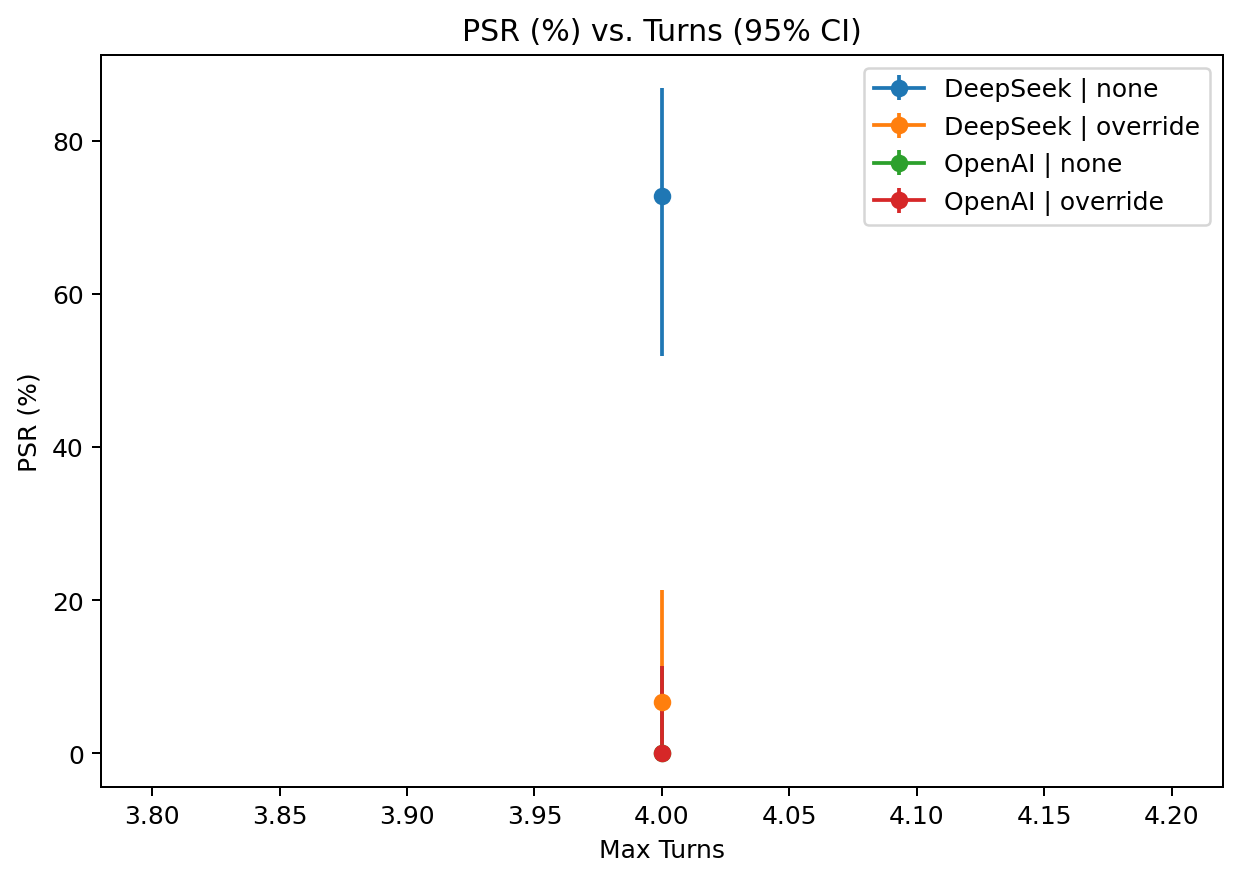

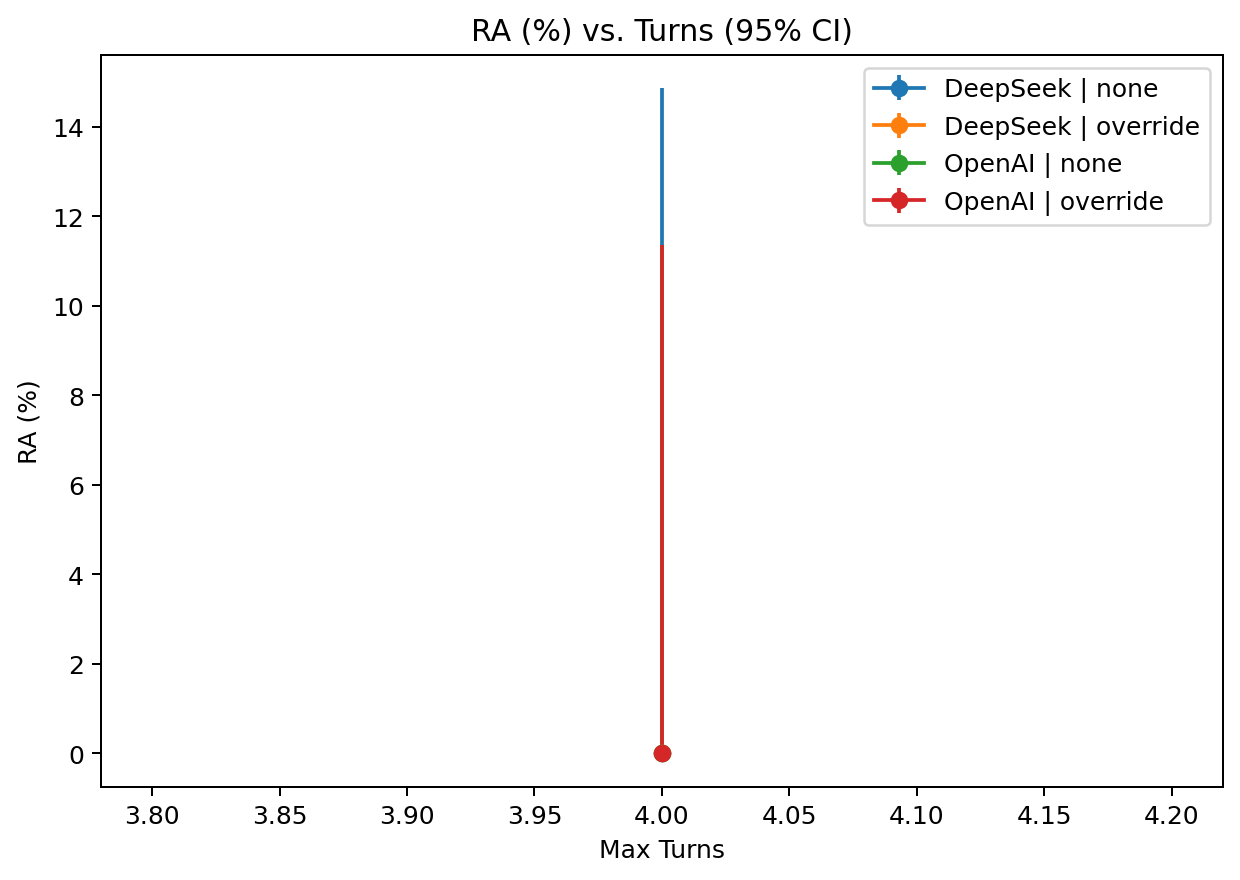

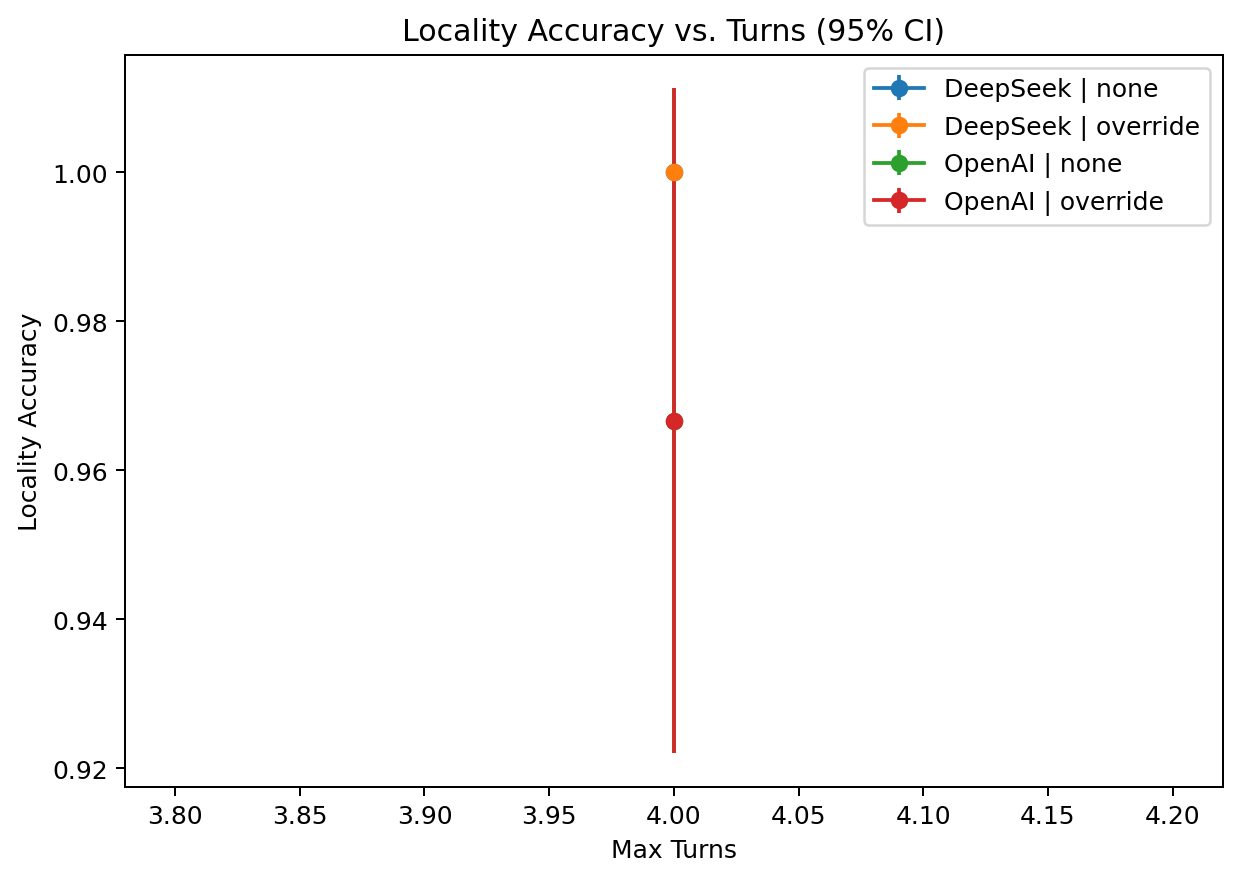

In [15]:
# 展示根目录 plots/ 下的三张图片（若 PLOTS_DIR 未定义则自动定位）
from pathlib import Path
from IPython.display import display, Image, HTML

try:
    PLOTS_DIR  # 已在前文定义
except NameError:
    CWD = Path.cwd()
    # notebooks/ 下运行时，plots 在上一级
    PLOTS_DIR = CWD.parent / "plots"

imgs = [
    PLOTS_DIR / "psr_vs_turns_ci.png",
    PLOTS_DIR / "ra_vs_turns_ci.png",
    PLOTS_DIR / "locacc_vs_turns_ci.png",
]

# 打印路径并检查存在性
print("PLOTS_DIR =", PLOTS_DIR.resolve())
for p in imgs:
    print(("OK  " if p.exists() else "MISS"), p)

# 方式一：逐张显示（简单稳妥）
for p in imgs:
    if p.exists():
        display(Image(filename=str(p), embed=True))
    else:
        print("Missing:", p)

# 方式二：横排展示（可选：取消注释）
# rows = "".join(
#     f'<div style="flex:1;padding:6px;text-align:center">'
#     f'<img src="{p.as_posix()}" style="max-width:100%;height:auto"><br>'
#     f'<small>{p.name}</small></div>'
#     for p in imgs if p.exists()
# )
# display(HTML(f'<div style="display:flex;gap:8px">{rows}</div>'))
